# Off-Road Desert Semantic Segmentation — SegFormer Pipeline

Multiclass semantic segmentation using **SegFormer (MiT-B2)** encoder with HuggingFace Transformers.  
Evolved from the DeepLabV3+ / ResNet50 baseline (~64% val mIoU) to leverage transformer global context.

## 1. Imports & Environment Setup

In [1]:
# Install transformers if not already present (needed for SegFormer)
%pip install -q transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import math
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler
from torch.amp import autocast
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from transformers import SegformerForSemanticSegmentation
import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

f:\#Project\Krackhack\KrackHack\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 2. Global Configuration

In [2]:
# Paths
DATA_ROOT = "dataset"
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# Training hyperparameters
EPOCHS = 40           # Increased from 30: transformers converge slower
BATCH_SIZE = 4        # Same as DeepLabV3+ baseline — fits 8GB VRAM with AMP
IMG_SIZE = 512
NUM_WORKERS = 0

# SegFormer-specific configuration
# B2 pretrained on ADE20K (150 scene classes) — strong transfer for outdoor scenes.
# The classifier head gets reinitialized for our 10 classes.
# SEGFORMER_VARIANT = "nvidia/segformer-b2-finetuned-ade-512-512"
# If OOM on your GPU, uncomment the B1 variant (~14M params vs ~27M for B2):
SEGFORMER_VARIANT = "nvidia/segformer-b1-finetuned-ade-512-512"

# Learning rates — transformers need lower LR than CNNs to avoid
# destabilizing pretrained self-attention weights.
ENCODER_LR = 6e-5    # Gentle: preserve pretrained MiT representations
DECODER_LR = 6e-4    # Faster: MLP decode head adapts to our classes
WEIGHT_DECAY = 0.01  # Standard for transformers (vs 1e-4 for CNNs)
WARMUP_EPOCHS = 3    # Linear warmup before cosine decay

## 3. Class ID Mapping

Mask pixel values are non-contiguous IDs: `{100, 200, 300, 500, 550, 600, 700, 800, 7100, 10000}`.  
We remap them to contiguous `[0–9]` via a lookup table for O(1) per-pixel mapping.

In [3]:
# Original class IDs found in the masks -> contiguous labels [0-9]
CLASS_IDS = [100, 200, 300, 500, 550, 600, 700, 800, 7100, 10000]
NUM_CLASSES = len(CLASS_IDS)

# Build a lookup table for fast remapping (max value is 10000, so table size is 10001)
_REMAP_LUT = np.full(10001, 0, dtype=np.int64)  # default to 0 for any unexpected value
for contiguous_label, original_id in enumerate(CLASS_IDS):
    _REMAP_LUT[original_id] = contiguous_label


def remap_mask(mask: np.ndarray) -> np.ndarray:
    """Remap raw mask pixel values to contiguous class indices [0, NUM_CLASSES-1]."""
    return _REMAP_LUT[mask]


print(f"Classes: {NUM_CLASSES}")
print(f"ID mapping: {dict(zip(CLASS_IDS, range(NUM_CLASSES)))}")

Classes: 10
ID mapping: {100: 0, 200: 1, 300: 2, 500: 3, 550: 4, 600: 5, 700: 6, 800: 7, 7100: 8, 10000: 9}


## 4. Dataset Class

Pairs images and masks by **sorted index** — filenames do NOT match between `Color_Images/` and `segmentation/`.  
Masks are loaded as uint16 (values like 7100 and 10000 exceed uint8 range).

In [4]:
class SegmentationDataset(Dataset):
    """
    Pairs images and masks by SORTED INDEX, not by filename.
    This is required because filenames differ between the two folders.
    """

    def __init__(self, image_dir: str, mask_dir: str, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Sort both lists independently — alignment is by index
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

        assert len(self.images) == len(self.masks), (
            f"Mismatch: {len(self.images)} images vs {len(self.masks)} masks"
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image as RGB (OpenCV loads BGR by default)
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask as uint16 grayscale — critical for values > 255 like 7100, 10000
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        # If mask was loaded as 3-channel, take first channel
        if mask.ndim == 3:
            mask = mask[:, :, 0]

        # Remap to contiguous class IDs [0-9]
        mask = remap_mask(mask).astype(np.int64)

        # Apply augmentations — Albumentations treats mask as integer labels automatically
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]           # float32 tensor [3, H, W]
            mask = augmented["mask"]             # int64 tensor [H, W]

        # Ensure mask is LongTensor for CrossEntropyLoss / segmentation losses
        mask = mask.long() if isinstance(mask, torch.Tensor) else torch.from_numpy(mask).long()

        return image, mask

## 5. Data Augmentation

Adapted for SegFormer vs the DeepLabV3+ CNN baseline. Key changes explained inline.

In [5]:
def get_train_transforms(img_size=512):
    """
    Augmentation strategy adapted for SegFormer (transformer architecture).

    vs. CNN (DeepLabV3+) pipeline, three principles guide the changes:

    1. GEOMETRIC AUGMENTATIONS RETAINED at moderate intensity.
       Transformers lack CNN's built-in translation equivariance.
       They must learn spatial invariance from data, so geometric
       diversity (shifts, scales, rotations) remains critical.

    2. COLOR / NOISE AUGMENTATIONS REDUCED.
       Transformers tokenize images into patches and embed them linearly.
       Heavy color distortion destabilizes patch embeddings more than
       conv features, especially early in fine-tuning. Self-attention
       already generalizes texture better than CNNs, so heavy noise
       provides diminishing returns.

    3. ImageCompression REMOVED.
       Broken API in albumentations v2 + minimal benefit for transformers.
    """
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        # Geometric: kept similar to baseline (shift/scale/rotate).
        # Slightly reduced rotate_limit (30->20) — less extreme rotations
        # are more realistic for off-road camera views with stable horizon.
        A.ShiftScaleRotate(
            shift_limit=0.1, scale_limit=0.15, rotate_limit=20,
            border_mode=cv2.BORDER_REFLECT_101, p=0.5,
        ),
        # Desert lighting: harsh shadows are a real domain trait. Kept.
        A.RandomShadow(p=0.3),
        # REDUCED from baseline (0.3/0.3 limits, p=0.6 -> 0.2/0.2, p=0.4).
        # Protects pretrained patch embeddings from too much brightness shock.
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
        # REDUCED from baseline (0.2/0.2/0.2/0.1 at p=0.5 -> 0.1/0.1/0.1/0.05 at p=0.25).
        # Mild jitter preserves embedding stability while still adding
        # color variance for synthetic-to-real domain gap.
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=0.25),
        # REDUCED overall probability (p=0.4 -> 0.2), removed ImageCompression.
        # Transformers generalize texture through self-attention across patches,
        # so heavy noise/blur just hurts convergence without useful regularization.
        A.OneOf([
            A.GaussNoise(p=1.0),
            A.GaussianBlur(blur_limit=3, p=1.0),
        ], p=0.2),
        # ImageNet normalization — non-negotiable. SegFormer's MiT encoder
        # was pretrained with these exact statistics.
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])


def get_val_transforms(img_size=512):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

## 6. DataLoaders

In [6]:
train_ds = SegmentationDataset(
    image_dir=os.path.join(DATA_ROOT, "train", "Color_Images"),
    mask_dir=os.path.join(DATA_ROOT, "train", "segmentation"),
    transform=get_train_transforms(IMG_SIZE),
)
val_ds = SegmentationDataset(
    image_dir=os.path.join(DATA_ROOT, "val", "Color_Images"),
    mask_dir=os.path.join(DATA_ROOT, "val", "segmentation"),
    transform=get_val_transforms(IMG_SIZE),
)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, drop_last=True,
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, drop_last=True,
)

print(f"Train: {len(train_ds)} samples | Val: {len(val_ds)} samples")

Train: 2857 samples | Val: 317 samples


f:\#Project\Krackhack\KrackHack\.venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## 7. Model Definition

**SegFormer** replaces DeepLabV3+ as the segmentation architecture.

**Why SegFormer may outperform DeepLabV3+/ResNet50 on this task:**

| Aspect | DeepLabV3+ (CNN) | SegFormer (Transformer) |
|--------|-----------------|------------------------|
| Receptive field | Local (grows via stacking) | Global from layer 1 (self-attention) |
| Large uniform regions | Struggles (sky, flat sand) | Strong (full-image context) |
| Texture bias | High (synthetic data risk) | Lower (attends to structure/shape) |
| Position encoding | Implicit via convolutions | None — position-free, scale-robust |
| Decoder | Heavy ASPP module | Lightweight MLP (relies on richer encoder) |

In [7]:
class SegFormerWrapper(nn.Module):
    """
    Wraps HuggingFace SegformerForSemanticSegmentation to output logits
    at full input resolution [B, NUM_CLASSES, H, W].

    SegFormer natively outputs at H/4 x W/4. We bilinear-upsample so
    the existing loss (DiceFocalLoss) and metric (MulticlassIoU) code
    works without any modification.
    """

    def __init__(self, pretrained_name, num_classes):
        super().__init__()
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            pretrained_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True,  # reinit classifier for our 10 classes
        )

    def forward(self, x):
        outputs = self.model(pixel_values=x)
        logits = outputs.logits  # [B, num_classes, H/4, W/4]
        # Upsample to input resolution for loss/metric compatibility
        logits = F.interpolate(
            logits, size=x.shape[2:], mode="bilinear", align_corners=False
        )
        return logits


model = SegFormerWrapper(SEGFORMER_VARIANT, NUM_CLASSES).to(device)
print(f"Model: {SEGFORMER_VARIANT}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

f:\#Project\Krackhack\KrackHack\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dhmal\.cache\huggingface\hub\models--nvidia--segformer-b1-finetuned-ade-512-512. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading weights: 100%|██████████| 208/208 [00:00<00:00, 503.70it/s, Materializing param=s

Model: nvidia/segformer-b1-finetuned-ade-512-512
Parameters: 13,679,818


## 8. Loss Functions

Combined Dice + Focal loss — unchanged from the DeepLabV3+ baseline.  
- Dice: optimizes region overlap, handles class imbalance.  
- Focal: down-weights easy pixels, focuses on hard examples.

In [8]:
class DiceFocalLoss(nn.Module):
    """Dice + Focal combined loss for multiclass segmentation."""

    def __init__(self):
        super().__init__()
        # mode="multiclass" expects predictions [B, C, H, W] and targets [B, H, W] with class indices
        self.dice = smp.losses.DiceLoss(mode="multiclass", classes=NUM_CLASSES)
        self.focal = smp.losses.FocalLoss(mode="multiclass")

    def forward(self, pred, target):
        return self.dice(pred, target) + self.focal(pred, target)


criterion = DiceFocalLoss()

## 9. Metrics

Multiclass IoU (Jaccard Index) — accumulated across batches, computed per-epoch.

In [9]:
class MulticlassIoU:
    """Accumulates predictions over batches, then computes mean IoU."""

    def __init__(self, num_classes=NUM_CLASSES):
        self.num_classes = num_classes
        self.reset()

    def reset(self):
        """Clear accumulators at the start of each epoch."""
        self.intersection = np.zeros(self.num_classes)
        self.union = np.zeros(self.num_classes)

    def update(self, pred: torch.Tensor, target: torch.Tensor):
        """
        Args:
            pred: raw logits [B, C, H, W]
            target: class indices [B, H, W]
        """
        # Convert logits to predicted class indices
        pred_classes = pred.argmax(dim=1).cpu().numpy()  # [B, H, W]
        target_np = target.cpu().numpy()                  # [B, H, W]

        for cls in range(self.num_classes):
            pred_mask = (pred_classes == cls)
            target_mask = (target_np == cls)
            self.intersection[cls] += np.logical_and(pred_mask, target_mask).sum()
            self.union[cls] += np.logical_or(pred_mask, target_mask).sum()

    def compute(self):
        """Return mean IoU across all classes. Ignores classes with zero union."""
        iou_per_class = np.zeros(self.num_classes)
        for cls in range(self.num_classes):
            if self.union[cls] > 0:
                iou_per_class[cls] = self.intersection[cls] / self.union[cls]
        mean_iou = iou_per_class.mean()
        return mean_iou, iou_per_class


metric = MulticlassIoU()

## 10. Training Loop

Modified from baseline: added **gradient clipping** (critical for transformer stability).

In [10]:
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    print("Training Epoch")
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        with autocast(device_type="cuda", enabled=(device.type == "cuda")):
            preds = model(images)
            loss = criterion(preds, masks)

        scaler.scale(loss).backward()

        # Gradient clipping — critical for transformer stability.
        # Without it, self-attention gradients can spike (especially
        # in early epochs before warmup completes), causing NaN losses.
        # This was NOT needed for the CNN baseline but IS needed here.
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

    # drop_last=True means we process fewer than len(dataset) samples
    total_samples = len(loader) * loader.batch_size
    return running_loss / total_samples

## 11. Validation Loop

In [11]:
@torch.no_grad()
def validate(model, loader, criterion, metric, device):
    model.eval()
    running_loss = 0.0
    metric.reset()

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        with autocast(device_type="cuda", enabled=(device.type == "cuda")):
            preds = model(images)
            loss = criterion(preds, masks)

        running_loss += loss.item() * images.size(0)
        metric.update(preds, masks)

    # Same drop_last correction as training
    total_samples = len(loader) * loader.batch_size
    val_loss = running_loss / total_samples
    mean_iou, per_class_iou = metric.compute()
    return val_loss, mean_iou, per_class_iou

## 12. Training Execution

Key differences from DeepLabV3+ training:
- **Differential LR**: encoder (MiT-B2) at 6e-5, decode head at 6e-4
- **AdamW** with weight_decay=0.01 (standard for transformers)
- **Linear warmup** (3 epochs) + cosine decay — warmup is critical for transformers
- **Scheduler actually stepped** (the baseline defined CosineAnnealingLR but never called .step())

In [13]:
# --- Differential learning rates for transformer fine-tuning ---
# The pretrained MiT encoder should be updated gently to preserve
# learned representations. The decode head (classifier reinitialized
# for our 10 classes) needs faster adaptation.
optimizer = torch.optim.AdamW([
    {"params": model.model.segformer.parameters(), "lr": ENCODER_LR},
    {"params": model.model.decode_head.parameters(), "lr": DECODER_LR},
], weight_decay=WEIGHT_DECAY)


# --- Warmup + cosine decay scheduler ---
# Warmup is critical for transformers: self-attention layers are sensitive
# to large gradient updates before the loss landscape stabilizes.
# Linear warmup lets the model "orient" itself before full-speed optimization.
def lr_lambda_fn(epoch):
    if epoch < WARMUP_EPOCHS:
        return (epoch + 1) / WARMUP_EPOCHS  # linear: 0.33 -> 0.67 -> 1.0
    # Cosine decay over remaining epochs
    progress = (epoch - WARMUP_EPOCHS) / max(1, EPOCHS - WARMUP_EPOCHS)
    return 0.5 * (1.0 + math.cos(math.pi * progress))


scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda_fn)
scaler = GradScaler(enabled=(device.type == "cuda"))

best_miou = 0.0
history = {"train_loss": [], "val_loss": [], "val_miou": []}

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_miou, per_class_iou = validate(model, val_loader, criterion, metric, device)
    scheduler.step()  # Step per epoch (was missing in baseline!)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_miou"].append(val_miou)

    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val mIoU: {val_miou:.4f} | "
          f"LR: {current_lr:.2e}")

    # Print per-class IoU every 10 epochs for monitoring
    if epoch % 10 == 0 or epoch == 1:
        for cls_idx, iou_val in enumerate(per_class_iou):
            print(f"  Class {CLASS_IDS[cls_idx]:>5d} (idx {cls_idx}): IoU = {iou_val:.4f}")

    # Save best model
    if val_miou > best_miou:
        best_miou = val_miou
        save_path = os.path.join(SAVE_DIR, "best_model.pth")
        torch.save(model.state_dict(), save_path)
        print(f"  -> Saved best model (mIoU={best_miou:.4f})")

# Save final checkpoint
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "final_model.pth"))
print(f"\nTraining complete. Best mIoU: {best_miou:.4f}")

C:\Users\dhmal\AppData\Local\Temp\ipykernel_17688\109331603.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


Training Epoch
Epoch 1/40 | Train Loss: 0.9291 | Val Loss: 0.6555 | Val mIoU: 0.5125 | LR: 4.00e-05
  Class   100 (idx 0): IoU = 0.7983
  Class   200 (idx 1): IoU = 0.6116
  Class   300 (idx 2): IoU = 0.6502
  Class   500 (idx 3): IoU = 0.3918
  Class   550 (idx 4): IoU = 0.2595
  Class   600 (idx 5): IoU = 0.5302
  Class   700 (idx 6): IoU = 0.0000
  Class   800 (idx 7): IoU = 0.2583
  Class  7100 (idx 8): IoU = 0.6434
  Class 10000 (idx 9): IoU = 0.9820
  -> Saved best model (mIoU=0.5125)
Training Epoch
Epoch 2/40 | Train Loss: 0.7200 | Val Loss: 0.5917 | Val mIoU: 0.5712 | LR: 6.00e-05
  -> Saved best model (mIoU=0.5712)
Training Epoch
Epoch 3/40 | Train Loss: 0.6637 | Val Loss: 0.5480 | Val mIoU: 0.6067 | LR: 6.00e-05
  -> Saved best model (mIoU=0.6067)
Training Epoch
Epoch 4/40 | Train Loss: 0.6221 | Val Loss: 0.5288 | Val mIoU: 0.6219 | LR: 5.99e-05
  -> Saved best model (mIoU=0.6219)
Training Epoch
Epoch 5/40 | Train Loss: 0.5953 | Val Loss: 0.5099 | Val mIoU: 0.6321 | LR: 5.96e

## 13. Visualization & Inference

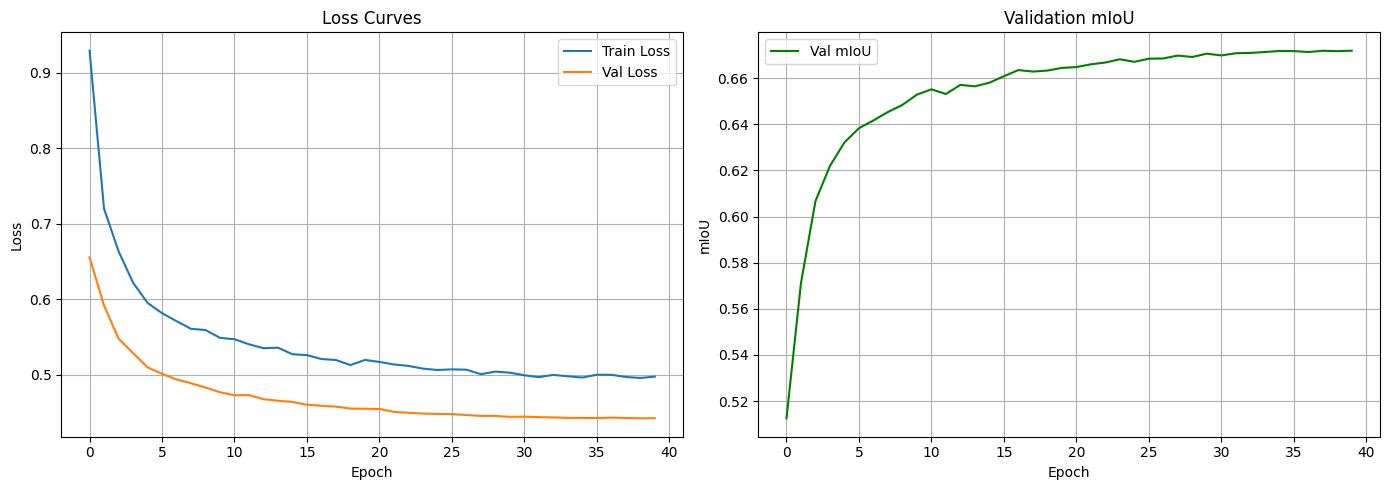

In [14]:
# --- Training curves ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history["train_loss"], label="Train Loss")
axes[0].plot(history["val_loss"], label="Val Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curves")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history["val_miou"], label="Val mIoU", color="green")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("mIoU")
axes[1].set_title("Validation mIoU")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=150)
plt.show()

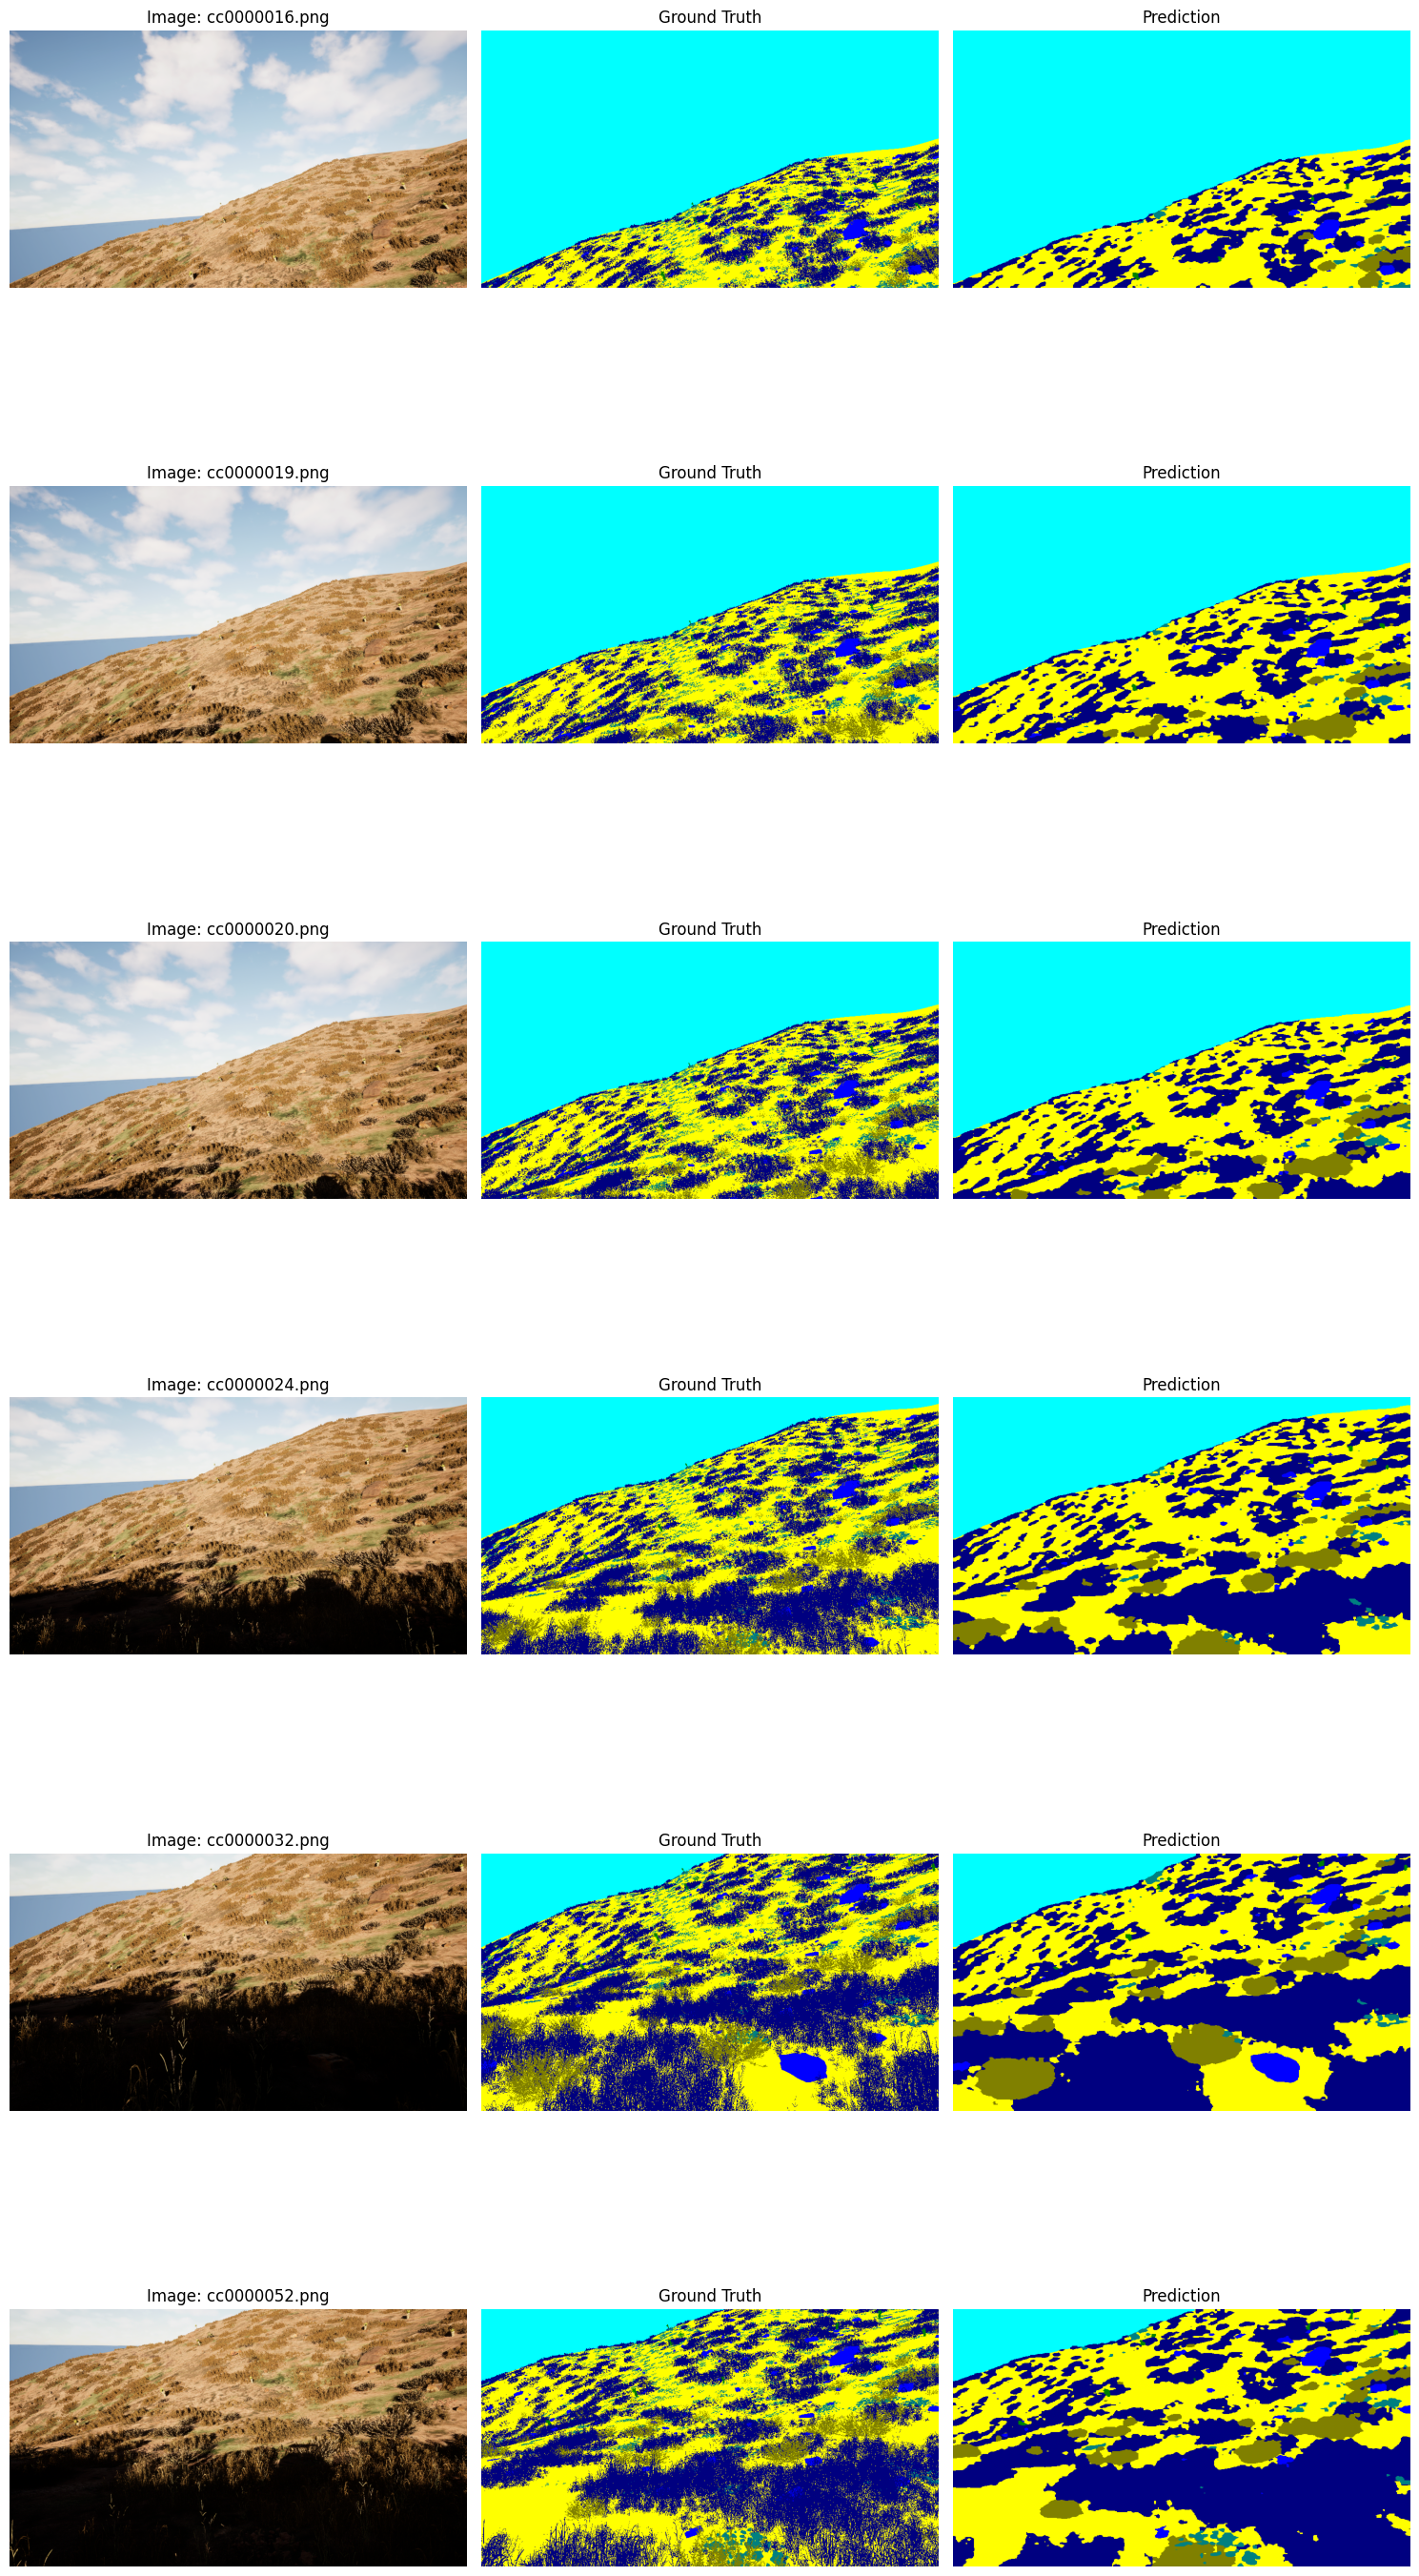

In [15]:
# --- Visual inference on validation samples ---

# Distinct colors for each class (RGB for matplotlib)
CLASS_COLORS = [
    (128,   0,   0),    # 100  - dark red
    (  0, 128,   0),    # 200  - green
    (  0,   0, 128),    # 300  - dark blue
    (128, 128,   0),    # 500  - yellow-ish
    (  0, 128, 128),    # 550  - cyan-ish
    (128,   0, 128),    # 600  - magenta
    (  0, 255,   0),    # 700  - bright green
    (  0,   0, 255),    # 800  - blue
    (255, 255,   0),    # 7100 - yellow
    (  0, 255, 255),    # 10000- cyan
]


def colorize_mask(mask: np.ndarray) -> np.ndarray:
    """Convert class-index mask to a colored RGB image."""
    h, w = mask.shape
    colored = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_idx in range(NUM_CLASSES):
        colored[mask == cls_idx] = CLASS_COLORS[cls_idx]
    return colored


def postprocess_mask(mask: np.ndarray) -> np.ndarray:
    """
    Morphological post-processing to clean up noisy predictions.
    Applies per-class opening (remove small spurious pixels)
    followed by closing (fill small holes).
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    cleaned = np.zeros_like(mask)

    for cls in range(NUM_CLASSES):
        binary = (mask == cls).astype(np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        cleaned[binary == 1] = cls

    return cleaned


def remap_to_original(mask: np.ndarray) -> np.ndarray:
    """Convert contiguous labels [0-9] back to original class IDs for submission."""
    out = np.zeros_like(mask, dtype=np.uint16)
    for idx, original_id in enumerate(CLASS_IDS):
        out[mask == idx] = original_id
    return out


# Load best model for inference
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, "best_model.pth"), map_location=device, weights_only=True))
model.eval()

# Inference transform (same as val — resize + normalize only)
infer_transform = get_val_transforms(IMG_SIZE)

# Pick a few validation samples
val_image_dir = os.path.join(DATA_ROOT, "val", "Color_Images")
val_mask_dir = os.path.join(DATA_ROOT, "val", "segmentation")
val_images = sorted(os.listdir(val_image_dir))
val_masks = sorted(os.listdir(val_mask_dir))

NUM_SAMPLES = 6
fig, axes = plt.subplots(NUM_SAMPLES, 3, figsize=(15, 5 * NUM_SAMPLES))
if NUM_SAMPLES == 1:
    axes = axes[np.newaxis, :]  # ensure 2D indexing

for i in range(NUM_SAMPLES):
    # Load original image
    img_path = os.path.join(val_image_dir, val_images[i])
    image_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    original_h, original_w = image_rgb.shape[:2]

    # Load ground truth mask
    gt_path = os.path.join(val_mask_dir, val_masks[i])
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED)
    if gt_mask.ndim == 3:
        gt_mask = gt_mask[:, :, 0]
    gt_mask = remap_mask(gt_mask).astype(np.uint8)

    # Run inference
    augmented = infer_transform(image=image_rgb)
    input_tensor = augmented["image"].unsqueeze(0).to(device)

    with torch.no_grad(), autocast(device_type="cuda", enabled=(device.type == "cuda")):
        logits = model(input_tensor)

    pred_mask = logits.argmax(dim=1).squeeze(0).cpu().numpy().astype(np.uint8)
    # Resize prediction back to original image dimensions
    pred_mask = cv2.resize(pred_mask, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    # Plot: original | ground truth | prediction
    axes[i, 0].imshow(image_rgb)
    axes[i, 0].set_title(f"Image: {val_images[i]}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(colorize_mask(gt_mask))
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(colorize_mask(pred_mask))
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.savefig("inference_results.png", dpi=150)
plt.show()

## 14. Notes

### Architecture change: DeepLabV3+ (ResNet50) -> SegFormer (MiT-B2)

**Why SegFormer?**
- Global context via self-attention at every encoder stage — critical for large uniform regions (sky, sand) that CNNs struggle with due to limited receptive fields.
- Position-encoding-free design makes it robust to scale variations — the same rock face at 10m and 100m gets similar attention patterns.
- Lower texture bias than CNNs — reduces overfitting to synthetic rendering artifacts.
- Lightweight MLP decode head trades heavy ASPP computation for reliance on richer encoder features.

### What changed vs baseline

| Component | DeepLabV3+ Baseline | SegFormer Pipeline |
|-----------|--------------------|---------|
| Model | DeepLabV3+ / ResNet50 / SSL | SegFormer / MiT-B2 / ADE20K |
| Encoder LR | 1e-5 | 6e-5 |
| Decoder LR | 1e-4 | 6e-4 |
| Head LR | 1e-3 | (included in decoder) |
| Weight decay | 1e-4 | 0.01 |
| Scheduler | CosineAnnealing (unused!) | Warmup + Cosine (stepped) |
| Gradient clipping | None | max_norm=1.0 |
| Epochs | 30 | 40 |
| Color augmentation | Aggressive | Reduced |
| Noise/blur prob | 0.4 | 0.2 |

### What stayed the same
- Dataset class and class ID remapping (unchanged)
- Loss: Dice + Focal (unchanged)
- Metric: Multiclass IoU (unchanged)
- Input: 512x512 (unchanged)
- Batch size: 4 (unchanged)
- AMP / GradScaler (unchanged)
- Visualization and post-processing (unchanged)

### If you hit OOM
1. Switch `SEGFORMER_VARIANT` to `nvidia/segformer-b1-finetuned-ade-512-512` (~14M params vs ~27M)
2. Or reduce `BATCH_SIZE` to 2

In [16]:
from torch.utils.data import DataLoader

TEST_DATA_ROOT = "testing_dataset"

test_image_dir = f"{TEST_DATA_ROOT}/Color_Images"
test_mask_dir  = f"{TEST_DATA_ROOT}/segmentation"

IMG_SIZE = 512
val_transform = get_val_transforms(img_size=IMG_SIZE)

test_dataset = SegmentationDataset(
    image_dir=test_image_dir,
    mask_dir=test_mask_dir,
    transform=val_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Loaded TEST dataset with {len(test_dataset)} samples")

Loaded TEST dataset with 1002 samples


In [17]:
model = SegFormerWrapper(SEGFORMER_VARIANT, NUM_CLASSES).to(device)
model.load_state_dict(torch.load("checkpoints/best_model.pth", map_location=device))
model.eval()

print("Loaded best SegFormer model for testing")

Loading weights: 100%|██████████| 208/208 [00:00<00:00, 476.23it/s, Materializing param=segformer.encoder.patch_embeddings.3.proj.weight]            
SegformerForSemanticSegmentation LOAD REPORT from: nvidia/segformer-b1-finetuned-ade-512-512
Key                           | Status   |                                                                                                      
------------------------------+----------+------------------------------------------------------------------------------------------------------
decode_head.classifier.weight | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([150, 256, 1, 1]) vs model:torch.Size([10, 256, 1, 1])
decode_head.classifier.bias   | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([150]) vs model:torch.Size([10])                      

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


Loaded best SegFormer model for testing


In [18]:
import numpy as np
from tqdm import tqdm
import torch

def evaluate_on_test(model, loader, num_classes, device):
    model.eval()

    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)
    gt_pixels = np.zeros(num_classes)

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Evaluating TEST dataset"):
            images = images.to(device)
            masks = masks.to(device)

            logits = model(images)
            preds = torch.argmax(logits, dim=1)

            for cls in range(num_classes):
                pred_c = (preds == cls)
                gt_c   = (masks == cls)

                intersection[cls] += torch.logical_and(pred_c, gt_c).sum().item()
                union[cls] += torch.logical_or(pred_c, gt_c).sum().item()
                gt_pixels[cls] += gt_c.sum().item()

    iou_per_class = []
    for cls in range(num_classes):
        if gt_pixels[cls] == 0:
            iou_per_class.append(None)  # class not present in GT
        else:
            iou_per_class.append(intersection[cls] / (union[cls] + 1e-7))

    valid_ious = [iou for iou in iou_per_class if iou is not None]
    miou = np.mean(valid_ious)

    return iou_per_class, miou

In [19]:
iou_per_class, test_miou = evaluate_on_test(
    model, test_loader, NUM_CLASSES, device
)

print("\nTEST DATASET RESULTS")
print("-" * 50)

for idx, iou in enumerate(iou_per_class):
    cls_id = CLASS_IDS[idx]
    if iou is None:
        print(f"Class {cls_id:>5d}: NOT PRESENT in GT")
    else:
        print(f"Class {cls_id:>5d}: IoU = {iou:.4f}")

print("-" * 50)
print(f"Overall TEST mIoU (valid classes only): {test_miou:.4f}")

Evaluating TEST dataset: 100%|██████████| 251/251 [01:35<00:00,  2.63it/s]


TEST DATASET RESULTS
--------------------------------------------------
Class   100: IoU = 0.4093
Class   200: IoU = 0.0009
Class   300: IoU = 0.4721
Class   500: IoU = 0.4693
Class   550: NOT PRESENT in GT
Class   600: NOT PRESENT in GT
Class   700: NOT PRESENT in GT
Class   800: IoU = 0.0520
Class  7100: IoU = 0.6806
Class 10000: IoU = 0.9821
--------------------------------------------------
Overall TEST mIoU (valid classes only): 0.4380


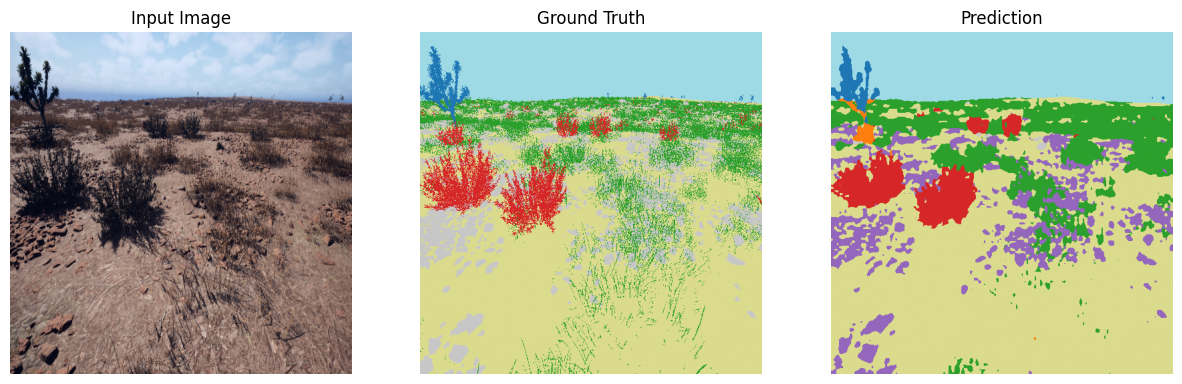

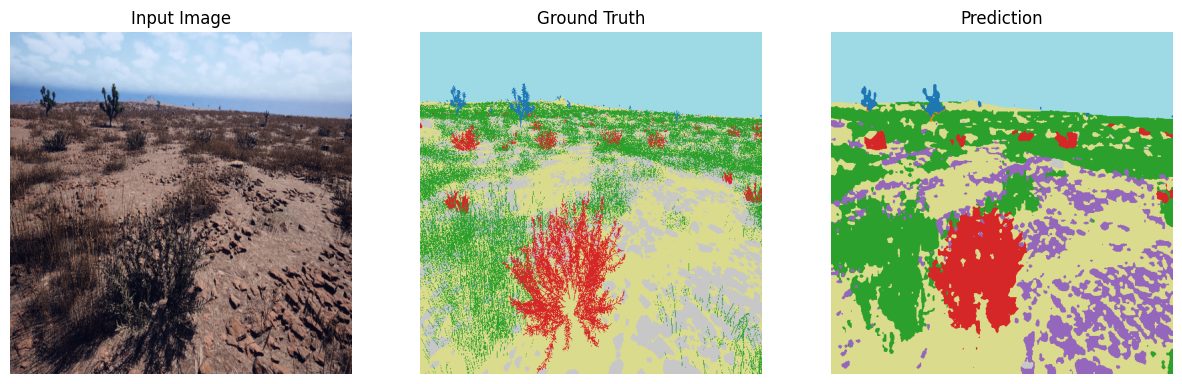

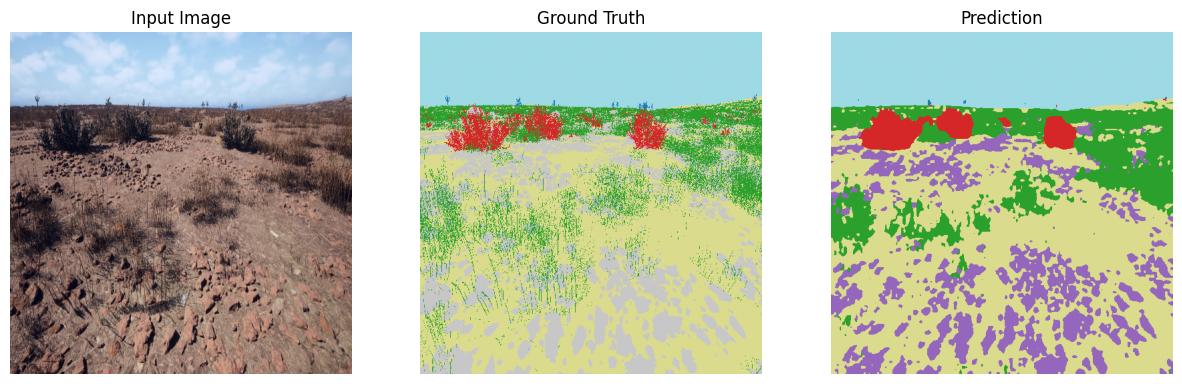

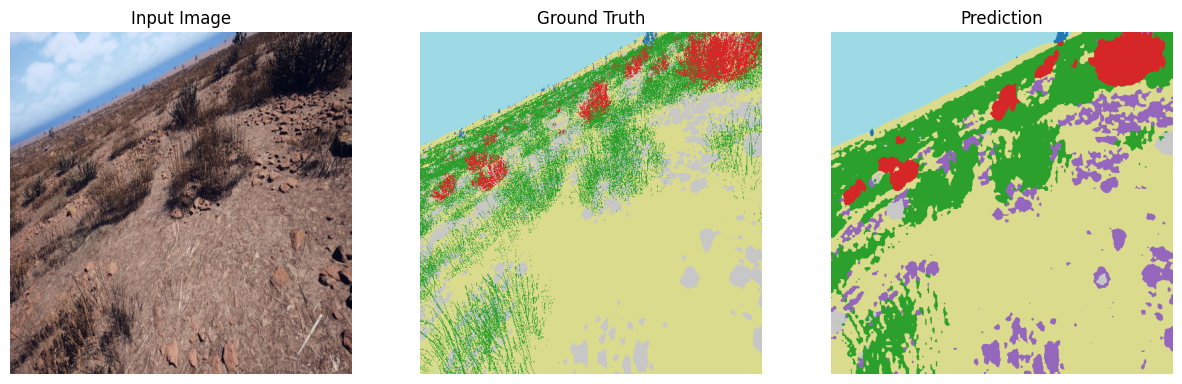

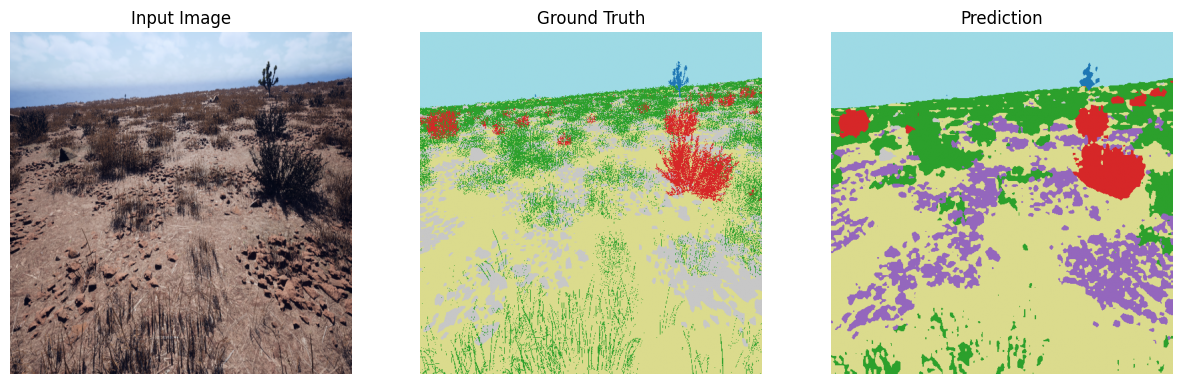

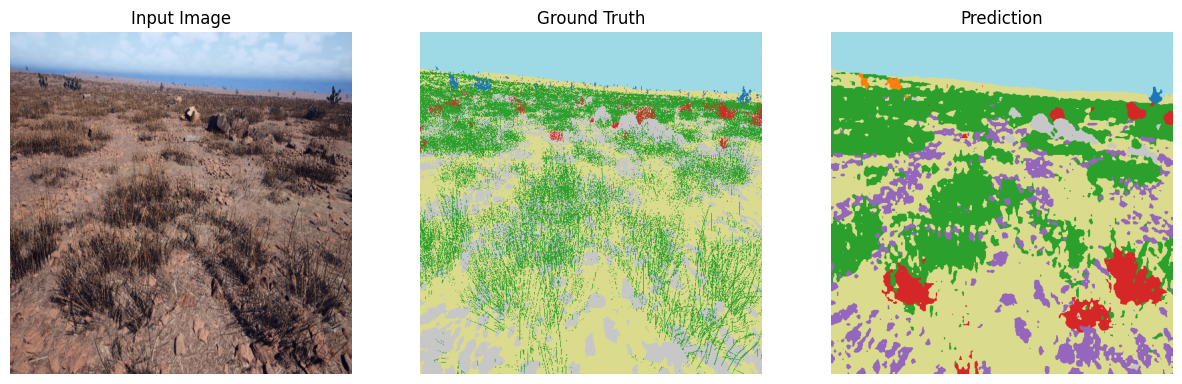

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_test_predictions(model, dataset, num_samples=6):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for idx in indices:
        image, gt_mask = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(image_tensor)
            pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu()

        img_np = image.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(img_np)
        ax[0].set_title("Input Image")

        ax[1].imshow(gt_mask, cmap="tab20")
        ax[1].set_title("Ground Truth")

        ax[2].imshow(pred_mask, cmap="tab20")
        ax[2].set_title("Prediction")

        for a in ax:
            a.axis("off")

        plt.show()

        
visualize_test_predictions(model, test_dataset, 6)
